<a href="https://colab.research.google.com/github/JinkyoHan/PINN_Elastic_Plate/blob/main/FvK_PDE_032.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINNs + FvK Equation

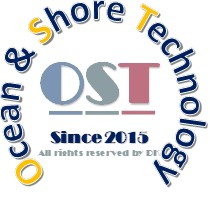

**V. 0.3.2**

Implemented by Jinkyo Han
38jinkyo@snu.ac.kr

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Problem Statements

E = 205900 # N/mm^2 or GPa
mu = 0.3

h = 0.1 # mm
q = 0 # N
a = 50 # mm
b = 50 # mm

D = E*h**3/(1-mu**2)/12.
C = E*h/(1 - mu**2)

u_disp = 0.5 # mm, how much to compress
eps_ = u_disp / 2 / a

# Shape Functions
func_u1 = lambda x: (x[:,0]-1)*(x[:,0]+1)*(x[:,0])
func_u2 = lambda x: (x[:,0])

func_v1 = lambda x: (x[:,1])

func_w = lambda x: (x[:,0]+1)*(x[:,0]-1)*(x[:,1]+1)*(x[:,1]-1)

In [3]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer

        self.Input = nn.Linear(n_input, n_nodes)
        nn.init.xavier_uniform_(self.Input.weight)
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)

        self.Hidden = nn.ModuleList()
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)


    def forward(self, x):
        y = torch.tanh(self.Input(x))
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

In [4]:
def derivatives_1(x, w):

    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    return dw_x, dw_y

In [5]:
def derivatives_2(x, w):

    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    # second partial derivative
    dw_xxy = torch.autograd.grad(dw_x, x, torch.ones_like(dw_x), retain_graph=True,
    create_graph=True,allow_unused=True)
    dw_xx = dw_xxy[0][:,0].view(-1,1)
    dw_xy = dw_xxy[0][:,1].view(-1,1)
    dw_yy = torch.autograd.grad(dw_y, x, torch.ones_like(dw_y), retain_graph=True,
    create_graph=True,allow_unused=True)[0][:,1].view(-1,1)

    return dw_x, dw_y, dw_xx, dw_yy, dw_xy

In [6]:
def derivatives_4(x, w):

    # 첫 번째 및 두 번째 도함수 계산
    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True, create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:, 0].view(-1, 1)
    dw_y = dw_xy[0][:, 1].view(-1, 1)

    # 두 번째 도함수 계산
    dw_xxy = torch.autograd.grad(dw_x, x, torch.ones_like(dw_x), retain_graph=True, create_graph=True, allow_unused=True)
    dw_xx = dw_xxy[0][:, 0].view(-1, 1)
    dw_xy = dw_xxy[0][:, 1].view(-1, 1)
    dw_yy = torch.autograd.grad(dw_y, x, torch.ones_like(dw_y), retain_graph=True, create_graph=True, allow_unused=True)[0][:, 1].view(-1, 1)

    # 네 번째 도함수 계산
    dw_xxxx = torch.autograd.grad(dw_xx, x, torch.ones_like(dw_xx), retain_graph=True, create_graph=True, allow_unused=True)[0][:, 0].view(-1, 1)
    dw_yyyy = torch.autograd.grad(dw_yy, x, torch.ones_like(dw_yy), retain_graph=True, create_graph=True, allow_unused=True)[0][:, 1].view(-1, 1)
    dw_xxyy = torch.autograd.grad(dw_xy, x, torch.ones_like(dw_xy), retain_graph=True, create_graph=True, allow_unused=True)[0][:, 1].view(-1, 1)

    return dw_x, dw_y, dw_xx, dw_yy, dw_xy, dw_xxxx, dw_yyyy, dw_xxyy


In [17]:
def FvK_equation(x, Net_w, Net_u, Net_v):

    w = Net_w(x) * (func_w(x).view(-1, 1))
    u = Net_u(x) * (func_u1(x).view(-1, 1)) - eps_ * (func_u2(x).view(-1, 1))
    v = Net_v(x) * (func_v1(x).view(-1, 1))

    # Calculate Derivatives
    dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(x, w)
    du_x, du_y = derivatives_1(x, u)
    dv_x, dv_y = derivatives_1(x, v)

    #dw_xxxx, dw_yyyy, dw_xxyy = derivatives_4(x, Net_w, func_w)

    # Dimensionalize parameters
    w, u, v = w*h, u*a, v*b
    dw_x, dw_y = dw_x*h/a, dw_y*h/b
    du_x, du_y = du_x*a/a, du_y*a/b
    dv_x, dv_y = dw_x*b/a, dw_y*b/b
    dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b
    #du_xx, du_yy, du_xy = du_xx*a/a**2, du_yy*a/b**2, du_xy*a/a/b
    #dv_xx, dv_yy, dv_xy = dv_xx*b/a**2, dv_yy*b/b**2, dv_xy*b/a/b
    #dw_xxxx, dw_yyyy, dw_xxyy = dw_xxxx*h/a**4, dw_yyyy*h/b**4, dw_xxyy*h/a**2/b**2

      # Resultants
    N_xx = C*((du_x+0.5*dw_x**2) + mu*(dv_y+0.5*dw_y**2))
    N_yy = C*((dv_y+0.5*dw_y**2) + mu*(du_x+0.5*dw_x**2))
    N_xy = C*(1 - mu)*0.5*(du_y+dv_x+dw_x*dw_y)

    M_xx = -D*(dw_xx+mu*dw_yy)
    M_yy = -D*(dw_yy+mu*dw_xx)
    M_xy = -D*(1 - mu)*dw_xy

    # 2nd derivative of dM_xx
    dM_xx_x = torch.autograd.grad(M_xx, x, torch.ones_like(M_xx),
    retain_graph=True, create_graph=True, allow_unused=True)[0][:,0].view(-1,1)
    dM_xx_xx = torch.autograd.grad(dM_xx_x, x, torch.ones_like(dM_xx_x),
    retain_graph=True, create_graph=True,allow_unused=True)[0][:,0].view(-1,1)

    # 2nd derivative of dM_yy
    dM_yy_y = torch.autograd.grad(M_yy, x, torch.ones_like(M_yy),
    retain_graph=True, create_graph=True, allow_unused=True)[0][:,1].view(-1,1)
    dM_yy_yy = torch.autograd.grad(dM_yy_y, x, torch.ones_like(dM_yy_y),
    retain_graph=True, create_graph=True,allow_unused=True)[0][:,1].view(-1,1)

    # 2nd derivative of dM_xy
    dM_xy_x = torch.autograd.grad(M_xy, x, torch.ones_like(M_xy),
    retain_graph=True, create_graph=True, allow_unused=True)[0][:,0].view(-1,1)
    dM_xy_xy = torch.autograd.grad(dM_xy_x, x, torch.ones_like(dM_xy_x),
    retain_graph=True, create_graph=True,allow_unused=True)[0][:,1].view(-1,1)

    # PDE: Classic FvK Equation
    # unit: N/mm^2
    PDE = (dM_xx_xx + 2*dM_xy_xy + dM_yy_yy + N_xx*dw_xx + 2*N_xy*dw_xy + N_yy*dw_yy + q)**2

    # BC: to be implemented by yourself.
    BC_v  = (N_yy[x[:,1]== -1]/a)**2
    BC_v += (N_yy[x[:,1]==  1]/a)**2

    BC_s  = (N_xy[x[:,0]== -1]/b)**2
    BC_s += (N_xy[x[:,0]==  1]/b)**2
    BC_s += (N_xy[x[:,1]== -1]/a)**2
    BC_s += (N_xy[x[:,1]==  1]/a)**2

    BC_m  = (M_xx[x[:,1]== -1]/a**2)**2
    BC_m += (M_xx[x[:,1]==  1]/a**2)**2
    BC_m += (M_yy[x[:,0]== -1]/b**2)**2
    BC_m += (M_yy[x[:,0]==  1]/b**2)**2

    BC = BC_v + BC_s + BC_m

    return torch.mean(PDE), torch.mean(BC)

In [18]:
def train_data(Nx, Ny, Nf):
    x = np.linspace(-1, 1, Nx).reshape([Nx, 1])
    y = np.linspace(-1, 1, Ny).reshape([Ny, 1])

    # 경계 포인트 생성
    Xb = np.vstack([np.hstack([x, np.full_like(x, -1)]),  # 아래쪽 경계
                    np.hstack([x, np.full_like(x, 1)]),   # 윗쪽 경계
                    np.hstack([np.full_like(y, -1), y]),  # 왼쪽 경계
                    np.hstack([np.full_like(y, 1), y])])  # 오른쪽 경계
    Xb = np.unique(Xb, axis=0)
    Xf1 = torch.tensor(Xb, dtype=torch.float32, requires_grad=True)

    # 내부 포인트 생성
    while True:
        Xf2 = np.random.rand(Nf, 2) * 2 - 1
        # 경계선에 있는 포인트 제거
        Xf2 = Xf2[~((np.isclose(Xf2[:, 0], -1) | np.isclose(Xf2[:, 0], 1)) |
                    (np.isclose(Xf2[:, 1], -1) | np.isclose(Xf2[:, 1], 1)))]
        if len(Xf2) >= Nf:
            break
    Xf2 = Xf2[:Nf]
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)

    return Xf1, Xf2


In [19]:
# Prepare training data
Nx1 = 30
Ny1 = 30
Nf1 = 8000

Xf1, Xf2 = train_data(Nx1, Ny1, Nf1)
Xf = torch.cat([Xf1, Xf2], dim=0)

Net_w = Net(2, 1, 6,6)
Net_u = Net(2, 1, 6,6)
Net_v = Net(2, 1, 6,6)

In [20]:
# Pretraining the neural network to fit different initial buckling mode
nepoches = 2000
learning_rate = 2e-3
# optimizer_w = torch.optim.Adam(Net_w.parameters(), lr=learning_rate)
# optimizer_f = torch.optim.Adam(Net_f.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(Net_w.parameters()) + list(Net_u.parameters()) + list(Net_v.parameters()),
                             lr= learning_rate)
for epoch in range(nepoches):

    w = Net_w(Xf2) * (func_w(Xf2).view(-1, 1))
    u = Net_u(Xf2) * (func_u1(Xf2).view(-1, 1)) - eps_ * (func_u2(Xf2).view(-1, 1))
    v = Net_v(Xf2) * (func_v1(Xf2).view(-1, 1))

    loss1 = torch.mean((w - 0.1*torch.cos(Xf2[:,0].view(-1,1)*3.14*0.5)*torch.cos(Xf2[:,1].view(-1,1)*3.14*0.5))**2)
    loss2 = torch.mean((u + eps_*(Xf2[:,0].view(-1,1)))**2)
    loss3 = torch.mean(((v - mu*eps_*(Xf2[:,1].view(-1,1)))/mu)**2)

    loss1.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss2.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss3.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}, Loss1:{loss1:.4e}, Loss2:{loss2:.4e}, Loss3:{loss3:.4e}')

epoch:100, Loss1:3.1810e-05, Loss2:1.0132e-05, Loss3:3.8511e-01
epoch:200, Loss1:6.1415e-06, Loss2:4.6327e-06, Loss3:1.5527e-03
epoch:300, Loss1:6.1326e-06, Loss2:3.0468e-06, Loss3:3.6575e-07
epoch:400, Loss1:6.1233e-06, Loss2:2.1199e-06, Loss3:3.1913e-07
epoch:500, Loss1:6.1124e-06, Loss2:1.5498e-06, Loss3:3.1844e-07
epoch:600, Loss1:6.0998e-06, Loss2:1.1848e-06, Loss3:3.1768e-07
epoch:700, Loss1:6.0855e-06, Loss2:9.3915e-07, Loss3:3.1684e-07
epoch:800, Loss1:6.0693e-06, Loss2:7.6412e-07, Loss3:3.1590e-07
epoch:900, Loss1:6.0511e-06, Loss2:6.3277e-07, Loss3:3.1488e-07
epoch:1000, Loss1:6.0307e-06, Loss2:5.3048e-07, Loss3:3.1378e-07
epoch:1100, Loss1:6.0080e-06, Loss2:4.4922e-07, Loss3:3.1259e-07
epoch:1200, Loss1:5.9825e-06, Loss2:3.8423e-07, Loss3:3.1133e-07
epoch:1300, Loss1:5.9541e-06, Loss2:3.3226e-07, Loss3:3.0997e-07
epoch:1400, Loss1:5.9223e-06, Loss2:2.9084e-07, Loss3:3.0853e-07
epoch:1500, Loss1:5.8866e-06, Loss2:2.5792e-07, Loss3:3.0701e-07
epoch:1600, Loss1:5.8464e-06, Loss

In [21]:
# Pretraining the neural network to fit different initial buckling mode
nepoches = 1500
learning_rate = 2e-3
# optimizer_w = torch.optim.Adam(Net_w.parameters(), lr=learning_rate)
# optimizer_f = torch.optim.Adam(Net_f.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(Net_w.parameters()) + list(Net_u.parameters()) + list(Net_v.parameters()),
                             lr= learning_rate)
for epoch in range(nepoches):

    PDE, BC = FvK_equation(Xf, Net_w, Net_u, Net_v)

    loss = PDE + BC

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}, Total:{loss:.4e}')

epoch:100, Total:1.5179e-01
epoch:200, Total:7.4177e-02
epoch:300, Total:4.5601e-02
epoch:400, Total:2.9104e-02
epoch:500, Total:1.8292e-02
epoch:600, Total:1.2668e-02
epoch:700, Total:9.4413e-03
epoch:800, Total:7.5890e-03
epoch:900, Total:6.5394e-03
epoch:1000, Total:6.1111e-03
epoch:1100, Total:5.1869e-03
epoch:1200, Total:4.7574e-03
epoch:1300, Total:4.4081e-03
epoch:1400, Total:4.1269e-03
epoch:1500, Total:3.8504e-03


In [22]:
# Actual training to get the buckled solution
nepoches = 3000
learning_rate = 1e-4
optimizer = torch.optim.Adam(list(Net_w.parameters()) + list(Net_u.parameters()) + list(Net_v.parameters()),
                             lr= learning_rate)

for epoch in range(nepoches):
    ## Calculate loss
    PDE, BC = FvK_equation(Xf, Net_w, Net_u, Net_v)

    loss = PDE + BC

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    #if (epoch+1) % 200 == 0:
    Xf1, Xf2 = train_data(Nx1, Ny1, Nf1)
    Xf = torch.cat([Xf1, Xf2], dim=0)

    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}, Total:{loss:.4e}, PDE:{PDE:.4e}, BC:{BC:.4e}')

epoch:100, Total:3.8292e-03, PDE:8.1866e-04, BC:3.0105e-03
epoch:200, Total:3.7180e-03, PDE:7.8200e-04, BC:2.9360e-03
epoch:300, Total:3.6454e-03, PDE:7.8925e-04, BC:2.8562e-03
epoch:400, Total:3.5409e-03, PDE:7.6789e-04, BC:2.7730e-03
epoch:500, Total:3.4491e-03, PDE:7.5979e-04, BC:2.6894e-03
epoch:600, Total:3.3614e-03, PDE:7.5405e-04, BC:2.6074e-03
epoch:700, Total:3.2769e-03, PDE:7.4957e-04, BC:2.5274e-03
epoch:800, Total:3.1663e-03, PDE:7.1646e-04, BC:2.4498e-03
epoch:900, Total:3.0899e-03, PDE:7.1493e-04, BC:2.3750e-03
epoch:1000, Total:3.0272e-03, PDE:7.2433e-04, BC:2.3029e-03
epoch:1100, Total:2.9418e-03, PDE:7.0831e-04, BC:2.2335e-03
epoch:1200, Total:2.8507e-03, PDE:6.8424e-04, BC:2.1665e-03
epoch:1300, Total:2.7598e-03, PDE:6.5826e-04, BC:2.1015e-03
epoch:1400, Total:2.7020e-03, PDE:6.6313e-04, BC:2.0389e-03
epoch:1500, Total:2.6264e-03, PDE:6.4810e-04, BC:1.9783e-03
epoch:1600, Total:2.5437e-03, PDE:6.2428e-04, BC:1.9194e-03
epoch:1700, Total:2.4554e-03, PDE:5.9326e-04, BC:

In [23]:
x = np.linspace(-1,1,120).reshape([120,1])
y = np.linspace(-1,1,120).reshape([120,1])
X, Y = np.meshgrid(x, y)
Xf = np.vstack([X.ravel(), Y.ravel()]).T
Xf = torch.tensor(Xf, dtype=torch.float32, requires_grad=True)

w = Net_w(Xf) * (func_w(Xf).view(-1, 1))
u = Net_u(Xf) * (func_u1(Xf).view(-1, 1)) - eps_ * (func_u2(Xf).view(-1, 1))
v = Net_v(Xf) * (func_v1(Xf).view(-1, 1))

# Calculate Derivatives
dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(Xf, w)
du_x, du_y, du_xx, du_yy, du_xy = derivatives_2(Xf, u)
dv_x, dv_y, dv_xx, dv_yy, dv_xy = derivatives_2(Xf, v)

# Dimensionalize parameters
w, u, v = w*h, u*a, v*b
dw_x, dw_y = dw_x*h/a, dw_y*h/b
du_x, du_y = du_x*a/a, du_y*a/b
dv_x, dv_y = dw_x*b/a, dw_y*b/b
dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b
du_xx, du_yy, du_xy = du_xx*a/a**2, du_yy*a/b**2, du_xy*a/a/b
dv_xx, dw_yy, dw_xy = dv_xx*b/a**2, dv_yy*b/b**2, dv_xy*b/a/b

N_xx = C*((du_x+0.5*dw_x**2) + mu*(dv_y+0.5*dw_y**2))
N_yy = C*((dv_y+0.5*dw_y**2) + mu*(du_x+0.5*dw_x**2))
N_xy = C*(1 - mu)*0.5*(du_y+dv_x+dw_x*dw_y)

M_xx = -D*(dw_xx+mu*dw_yy)
M_yy = -D*(dw_yy+mu*dw_xx)
M_xy = -D*(1 - mu)*dw_xy

dN_xx_x = C*(du_xx + dw_x*dw_xx + mu*dv_xy + mu*dw_y*dw_xy)
dN_xx_y = C*(du_xy + dw_x*dw_xy + mu*dv_yy + mu*dw_y*dw_yy)

dN_yy_x = C*(mu*du_xx + mu*dw_x*dw_xx + dv_xy + dw_y*dw_xy)
dN_yy_y = C*(mu*du_xy + mu*dw_x*dw_xy + dv_yy + dw_y*dw_yy)

dN_xy_x = 0.5*C*(du_xy + dv_xx + dw_xx*dw_y + dw_xy*dw_x)
dN_xy_y = 0.5*C*(du_yy + dv_xy + dw_xy*dw_y + dw_yy*dw_x)


X = Xf[:,0].detach().numpy().reshape(-1,1)*a
Y = Xf[:,1].detach().numpy().reshape(-1,1)*b

W = w.detach().numpy().reshape(-1,1)
U = u.detach().numpy().reshape(-1,1)
V = v.detach().numpy().reshape(-1,1)

N_xx = N_xx.detach().numpy().reshape(-1,1)
N_yy = N_yy.detach().numpy().reshape(-1,1)
M_xx = M_xx.detach().numpy().reshape(-1,1)
M_yy = M_yy.detach().numpy().reshape(-1,1)

du_x = du_x.detach().numpy().reshape(-1,1)
du_y = du_y.detach().numpy().reshape(-1,1)

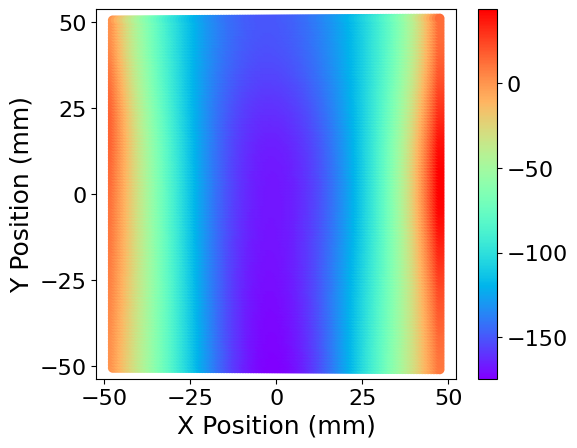

In [24]:
fig, ax = plt.subplots(figsize=(5.8, 4.8))

surf = ax.scatter(X+10*U, Y+10*V, c = N_xx, cmap=cm.rainbow)

cb = fig.colorbar(surf)

cb.ax.tick_params(labelsize=16)

ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
ax.set_xticks(ticks=[-50, -25, 0., 25, 50])
ax.set_yticks(ticks=[-50, -25, 0., 25, 50])
for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)

plt.show()


In [25]:
X = X.reshape(120,120)
Y = Y.reshape(120,120)
W = W.reshape(120,120)
U = U.reshape(120,120)
V = V.reshape(120,120)

N_xx = N_xx.reshape(120,120)
N_yy = N_yy.reshape(120,120)
M_xx = M_xx.reshape(120,120)
M_yy = M_yy.reshape(120,120)

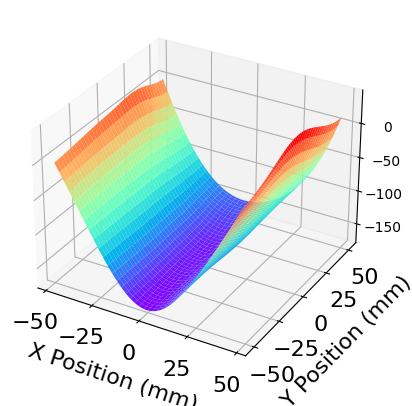

In [26]:
fig = plt.figure(figsize=(8, 4.8))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X+10*U, Y+10*V, N_xx, cmap=cm.rainbow)

cb.ax.tick_params(labelsize=16)

ax.set_xlabel('X Position (mm)', fontsize=16, labelpad=8)
ax.set_ylabel('Y Position (mm)', fontsize=16, labelpad=8)

ax.set_xticks(ticks=[-50, -25, 0., 25, 50])
ax.set_yticks(ticks=[-50, -25, 0., 25, 50])

for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)

plt.show()